# Signal to Noise Calculations for H clouds

In this code, I am calculating the signal-to-noise ratio as a function of exposure time, to find the time required for the Dragonfly telescope to match observations of H$\alpha$ emission performed by Donahue, Stocke, and Aldering (1995).  They performed narrowband H$\alpha$ imaging of several intergalactic clouds to low surface brightness of $\sim 10^{-18}$.  

The SNR is calculated following the equation: 

$SNR = \frac{I t}{\sqrt{I t + B t + D t + R^2}}$, 

where I is the signal over some number of pixels, B is the sky background over some number of pixels, D is the dark current over some number of pixels and R is the readout noise of the detector.  The exposure time, t, is usually given in seconds.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const
from astropy import units as u

In [2]:
# Testing out astropy a bit...
const.h.cgs

<Quantity 6.62606957e-27 erg s>

In [3]:
u.arcsec.to(u.rad)

4.84813681109536e-06

##Add the Dragonfly instrumentation data
Listing some values gathered from the Dragonfly Telephoto Instrumentation paper (Abraham and van Dokkum 2014), as well as sky background from the Gemini Sky Observatory (www.gemini.edu).

In [4]:
def Dragonfly():
    area_lens = np.pi*(14.3/2)**2 * 48. * u.cm**2
    pix_size = 2.8 # arcsec
    ang_size_pixel  = (pix_size * (1./206265.))**2 * u.rad**2   # rad^2, the pixel size of the CCD

    tau_l = 0.85  # transmittance of the Dragonfly lens
    QE = 0.48     # quantum efficiency of the CCDs
    tau_f = 1.    # transmittance of the Halpha filter -- assumed for now

    # The following are per pixel
    B = 0.52135 *u.photon/u.second/u.nm/u.arcsec**2/u.m**2   # sky background at 565.6 nm 
    D = 0.04 *u.photon/u.second                             # dark current (electrons / s) -- PER PIXEL??
    R_squared = 10.**2 * u.photon                           # read noise (electrons)

    # Donahue used 2' x 2' boxes to measure the sky brightness within
   # numpixels = [(2*60*2*60)/(pix_size**2)]            # for HI clouds
   # numpixels = np.array([(100.*100.)/(pix_size**2),   # for IGM filaments (from Bertone et al 2010, Fig2)
   #                       (10.*10.)/(pix_size**2),
   #                       1.]) 
   # numpixels = [7405.]                                  # for azithumally averaged galaxy, at radius 80kpc, distance 50 Mpc
    numpixels = [3700.]                                  # for azithumally averaged galaxy, at radius 80kpc, distance 100 Mpc
   # numpixels = [1.]                                      # for H alpha testing fields -Cygnus loop
    print('Number of pixels: '+str(numpixels))
    print('Area of the lens: '+str(area_lens))
    
    return [area_lens, ang_size_pixel, tau_l, tau_f, QE, B, D, R_squared, numpixels]

The surface brightness of the clouds stated by Donahue+ (1995) are listed below.

In [6]:
[area_lens, ang_size_pixel, tau_l, tau_f, QE, B, D, R_squared, numpixels] = Dragonfly()

wavelen = 656.3e-9 * u.m

### SB of H clouds (from Donahue et al 1995)
#SB_cgs = 1.4*10**-18 * u.erg / u.second / (u.cm**2) / u.arcsec**2
#SB_ph  = SB_cgs * wavelen / (const.h.cgs * const.c) / (u.arcsec.to(u.rad) * u.rad/u.arcsec)**2 * u.photon


### SB of extended halos (threshold from Stiedel et al 2011)
#SB_cgs = 1.597e-19 erg / (arcsec2 cm2 s)
SB_ph = 2245.38 * u.photon / (u.cm**2 * u.rad**2 * u.second)

### SB of IGM filaments (from Bertone series of papers, see SurfaceBrighnessCalcs.ipynb)
#SB_ph = 23870.257 * u.photon / (u.cm**2) / u.second / (u.rad**2)
#SB_ph = np.array([])

### SB of Cygnus loop (lowest SB of filaments, brightest is 5*10**-5)  Hester+1986
#SB_cgs = 10**-6 * u.erg / u.second / (u.cm**2) / u.rad**2  
#SB_cgs =  10**-5 * u.erg / u.second / (u.cm**2) / u.rad**2  
#SB_ph  = SB_cgs * wavelen / (const.h.cgs * const.c) * u.photon

print('Surface brightness: '+str(SB_ph))

Number of pixels: [3700.0]
Area of the lens: 7709.09138079 cm2
Surface brightness: 2245.38 ph / (cm2 rad2 s)


## SNR calculation
The signal-to-noise is calculated for the surface brightness listed above for an array of exposure times.  At some time, t, it reaches a SNR ~ 5, which is generally accepted as a reliable detection.

3700.0
0.00130142212931 ph / s
7709.09138079 cm2
Halpha Signal: 0.00130142212931 ph / s
Background Sky: 3.85681880622 ph / s


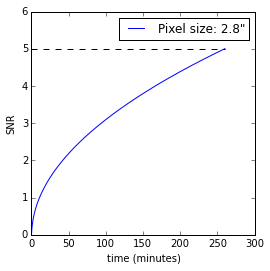

In [10]:
time = np.arange(0,60.*260.) * u.second   # Exposure Times 
plt.figure(figsize=(4,4))
size = np.array(['2.8"','10"','100"'])
i = 0
for numpixel in numpixels:
    print(numpixel)
    ## Signal = signal flux * QE * transmission * angular pixel size * area of the lens
    S = SB_ph * QE * tau_l * tau_f * area_lens * ang_size_pixel
    print(S)
    signal = S*time*numpixel
    print(area_lens)
    ## Noise
    B_tot = B * QE * tau_l * tau_f * 3.*u.nm * area_lens.to(u.m**2) * ang_size_pixel.to(u.arcsec**2)
    sigma = np.sqrt(signal + B_tot*time*numpixel + D*time*numpixel + R_squared*numpixel)

    # Note that the signal is about an eighth the strength of the background sky signal:
    print('Halpha Signal: '+str(S))
    print('Background Sky: ' +str(B_tot))

    #plt.plot(time, signal/np.sqrt(signal),label='Signal')
    #plt.plot(time, signal/np.sqrt(signal + B_tot*time),label='Signal + bkgd')
    #plt.plot(time, signal/np.sqrt(signal + B_tot*time + D*time),label='Signal + bkgd + dark curr')
    plt.plot(time/60., signal/sigma,label= 'Pixel size: '+size[i])
    i = i+1

plt.plot([0,260.],[5,5],'k--')    
plt.legend()
    
plt.xlabel('time (minutes)')
plt.ylabel('SNR')
plt.savefig('FigSNR.pdf')

1275.51020408
0.0138351996955 ph / s
Halpha Signal: 0.0138351996955 ph / s
Background Sky: 3.85681880622 ph / s
12.7551020408
0.0138351996955 ph / s
Halpha Signal: 0.0138351996955 ph / s
Background Sky: 3.85681880622 ph / s
1.0
0.0138351996955 ph / s
Halpha Signal: 0.0138351996955 ph / s
Background Sky: 3.85681880622 ph / s


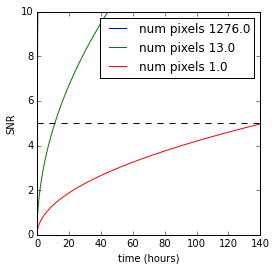

In [31]:
time = np.arange(0,200.*3600.) * u.second   # Exposure Times 
plt.figure(figsize=(4,4))

for numpixel in numpixels:
    print(numpixel)
    ## Signal = signal flux * QE * transmission * angular pixel size * area of the lens
    S = SB_ph * QE * tau_l * tau_f * area_lens * ang_size_pixel
    print(S)
    signal = S*time*numpixel

    ## Noise
    B_tot = B * QE * tau_l * tau_f * 3.*u.nm * area_lens.to(u.m**2) * ang_size_pixel.to(u.arcsec**2)
    sigma = np.sqrt(signal + B_tot*time*numpixel + D*time*numpixel + R_squared*numpixel)

    # Note that the signal is about an eighth the strength of the background sky signal:
    print('Halpha Signal: '+str(S))
    print('Background Sky: ' +str(B_tot))

    #plt.plot(time, signal/np.sqrt(signal),label='Signal')
    #plt.plot(time, signal/np.sqrt(signal + B_tot*time),label='Signal + bkgd')
    #plt.plot(time, signal/np.sqrt(signal + B_tot*time + D*time),label='Signal + bkgd + dark curr')
    plt.plot(time/3600., signal/sigma,label= 'num pixels '+str(round(numpixel)))

plt.plot([0,150.],[5,5],'k--')    
plt.legend()
plt.xlim(0,140)
plt.ylim(0,10)
plt.xlabel('time (hours)')
plt.ylabel('SNR')
plt.savefig('FigSNR.pdf')

Number of pixels: [  1.27551020e+03   1.27551020e+01   1.00000000e+00]
Area of the lens: 7709.09138079 cm2
1275.51020408
0.138351996955 ph / s
Halpha Signal: 0.138351996955 ph / s
Background Sky: 38.5681880622 ph / s
12.7551020408
0.138351996955 ph / s
Halpha Signal: 0.138351996955 ph / s
Background Sky: 38.5681880622 ph / s
1.0
0.138351996955 ph / s
Halpha Signal: 0.138351996955 ph / s
Background Sky: 38.5681880622 ph / s


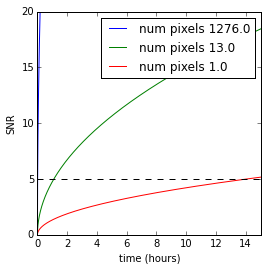

In [32]:
[area_lens, ang_size_pixel, tau_l, tau_f, QE, B, D, R_squared, numpixels] = Dragonfly()
wavelen = 656.3e-9 * u.m
SB_ph = 23870.257 * u.photon / (u.cm**2) / u.second / (u.rad**2)

time = np.arange(0,15.*3600.) * u.second   # Exposure Times 
area_lens = area_lens*10.                   # Increase size of Dragonfly to 500 lenses
plt.figure(figsize=(4,4))

for numpixel in numpixels:
    print(numpixel)
    ## Signal = signal flux * QE * transmission * angular pixel size * area of the lens
    S = SB_ph * QE * tau_l * tau_f * area_lens * ang_size_pixel
    print(S)
    signal = S*time*numpixel

    ## Noise
    B_tot = B * QE * tau_l * tau_f * 3.*u.nm * area_lens.to(u.m**2) * ang_size_pixel.to(u.arcsec**2)
    sigma = np.sqrt(signal + B_tot*time*numpixel + D*time*numpixel + R_squared*numpixel)

    # Note that the signal is about an eighth the strength of the background sky signal:
    print('Halpha Signal: '+str(S))
    print('Background Sky: ' +str(B_tot))

    #plt.plot(time, signal/np.sqrt(signal),label='Signal')
    #plt.plot(time, signal/np.sqrt(signal + B_tot*time),label='Signal + bkgd')
    #plt.plot(time, signal/np.sqrt(signal + B_tot*time + D*time),label='Signal + bkgd + dark curr')
    plt.plot(time/3600., signal/sigma,label= 'num pixels '+str(round(numpixel)))

plt.plot([0,15],[5,5],'k--')    
plt.legend()
plt.ylim(0,20)
plt.xlim(0,15)
plt.xlabel('time (hours)')
plt.ylabel('SNR')
plt.savefig('FigSNR.pdf')

##Double Check Donahue's values
Okay, this seems good.  Let's double check this calculation using values from the Donahue paper.  I can't find values for the quantum efficiency of the CCD or the transmission of the Kitt Peak telescope or the dark current, so I'm just going to use the same value as that of the Dragonfly CCD.

Number of pixels: 3494.38229513
Area of the lens: 2922.466566 cm2
19679.0446881 ph / (cm2 rad2 s)
Halpha Signal: 0.00227276597993 ph / s
Background Sky: 0.768513687779 ph / s


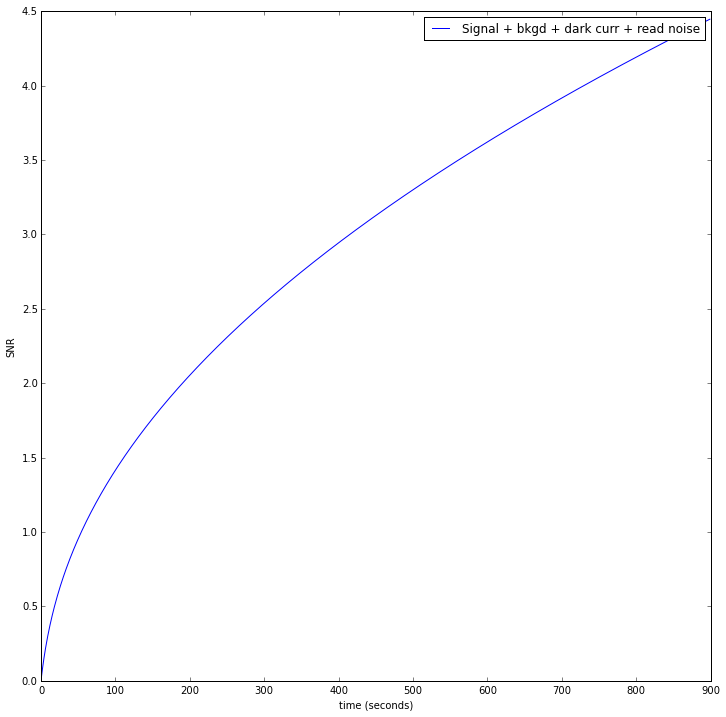

In [39]:
def Donahue():
    ## Donahue instrumention
    area_lens = np.pi*(61./2)**2 * u.cm**2
    pix_size = 2.03
    ang_size_pixel  = (pix_size * (1./206265.))**2 * u.rad**2   # rad^2, the pixel size of the telescope

    tau_l = 0.85  # transmittance of the Dragonfly lens
    QE = 0.48     # quantum efficiency of the Dragonfly CCDs
    tau_f = 1.    # transmittance of the Halpha filter -- UNKNOWN

    B = 0.52135 *u.photon/u.second/u.nm/u.arcsec**2/u.m**2   # avg sky background at 565.6 nm 
    D = 0.04 *u.photon/u.second     # dark current (electrons / s) 
    R_squared = 3.**2 * u.photon       # read noise (electrons)

    # Donahue used 2' x 2' boxes to measure the sky brightness within
    numpixels = (2*60*2*60)/(pix_size**2)
    print('Number of pixels: ' + str(numpixels))
    print('Area of the lens: '+str(area_lens))
    
    return [area_lens, ang_size_pixel, tau_l, tau_f, QE, B, D, R_squared, numpixels]

[area_lens, ang_size_pixel, tau_l, tau_f, QE, B, D, R_squared, numpixels] = Donahue()

wavelen = 656.3e-9 * u.m
SB_cgs = 1.4*10**-18 * u.erg / u.second / (u.cm**2) / u.arcsec**2
SB_ph  = SB_cgs * wavelen / (const.h.cgs * const.c) / (u.arcsec.to(u.rad) * u.rad/u.arcsec)**2 * u.photon
print(SB_ph)

time = np.arange(0,900.) * u.second   # Exposure Times 
S = SB_ph * QE * tau_l * tau_f * area_lens * ang_size_pixel
signal = S*time*numpixels

B_tot = B * QE * tau_l * tau_f * 3.*u.nm * area_lens.to(u.m**2) * ang_size_pixel.to(u.arcsec**2)
sigma = np.sqrt(signal + B_tot*time*numpixels + D*time*numpixels + R_squared*numpixels)

# Note that the signal is about an eighth the strength of the background sky signal:
print('Halpha Signal: '+str(S))
print('Background Sky: ' +str(B_tot))

plt.figure(figsize=(12,12))
#plt.plot(time, signal/np.sqrt(signal),label='Signal')
#plt.plot(time, signal/np.sqrt(signal + B_tot*time),label='Signal + bkgd')
#plt.plot(time, signal/np.sqrt(signal + B_tot*time + D*time),label='Signal + bkgd + dark curr')
plt.plot(time, signal/sigma,label='Signal + bkgd + dark curr + read noise')
plt.legend()
plt.xlabel('time (seconds)')
plt.ylabel('SNR')

So this seems about right.  

## SB of Donahue's non-detections

Donahue+ (2014) speculate that the above Halpha emission corresponding to the above SB of ~$1.9 * 10^4$ph/s/cm^2/sr is due to excitation of the gas from local effects from being near the two galaxies (since the spatial distribution looks like outflows and the Leo field of similar depth did not have a Halpha detection). 

I want to estimate the surface brightness of Halpha emission from the ionizing background radiation (more of an IGM effect).  I thought I'd do that by reversing the equation for the ionizing background and using some previous estimates of the ionizing background to predict how bright the Halpha emission should be (using the physics that Donahue+ 2014 assumed, as a first guess).  We can then repeat the above calculation, and figure out how much longer we'd have to observe to see Halpha emission in the regions where Donahue+ got non-detections.

The equation used by Donahue+(2014) has several factors that depend on the geometry of the cloud and the spectral shape of the ionizing background.  Since we don't really know what either of those are, I figured I could take the best case scenario, a good case scenario, a bad case scenario, and the worst case scenario.

1. Best case: Spherical cloud, high ionization background (assumed by Donahue et al 2014):  J$_0=2*10^{-22}$, f$_g$ = 1. , f$_s$ = 1. 
2. Medium case: Weird shaped clouds, high ionization background with sharp profile: J$_0=2*10^{-22}$, f$_g$ = 2., f$_s$ = 1.63
3. Medium case: Spherical clouds, low ionization background: J$_0=10^{-23}$, f$_g$ = 1., f$_s$ = 1.
4. Worst case: Weird shaped clouds, low ionization background: J$_0=10^{-23}$, f$_g$ = 2., f$_s$ = 1.63

In [40]:
# 1. Best case
J_0 = 2.*10**-22 *u.erg/u.second/u.cm**2/u.sr/u.Hz # to 10**-23
f_Halpha = 0.45
f_g = 1.  # max of 2
f_s = 1.  # max of 1.63
SB_Halpha_max = J_0 * f_Halpha / (const.h.cgs * f_g * f_s) * u.Hz * u.second * u.photon

print(SB_Halpha_max)
print(SB_Halpha_max/SB_ph)
print(1./(2.*1.63))

13582.7128057 ph / (cm2 s sr)
0.690212000684 rad2 / sr
0.306748466258


This surface brightness is about 2/3 of the SB calculated above.  If we use the lower bound for the ionizing background, the surface brightness is decreased by another order of magnitude.  If we use the non-ideal conditions for f_g and f_s and max them out, the surface brightness is a third of its value again.  Below, we do this calculation for two medium cases and for the most extreme case:

In [41]:
# 2. Medium case 1:  Weird shaped clouds, high ionization background with sharp spectral profile
J_0 = 2*10**-22 *u.erg/u.second/u.cm**2/u.sr/u.Hz # to 10**-23
f_Halpha = 0.45
f_g = 2. #2.  # max of 2
f_s = 1.63 #1.63  # max of 1.63
SB_Halpha_med1 = J_0 * f_Halpha / (const.h.cgs * f_g * f_s) * u.Hz * u.second * u.photon

print(SB_Halpha_med1)
print(SB_Halpha_med1/SB_ph)

# 3. Medium case 2: Spherical clouds, low ionization background
J_0 = 10**-23 *u.erg/u.second/u.cm**2/u.sr/u.Hz # to 10**-23
f_Halpha = 0.45
f_g = 1. #2.  # max of 2
f_s = 1. #1.63  # max of 1.63
SB_Halpha_med2 = J_0 * f_Halpha / (const.h.cgs * f_g * f_s) * u.Hz * u.second * u.photon

print(SB_Halpha_med2)
print(SB_Halpha_med2/SB_ph)

# 4. Worst case:  Weird shaped clouds, low ionization background with sharp spectral profile
J_0 = 10**-23 *u.erg/u.second/u.cm**2/u.sr/u.Hz # to 10**-23
f_Halpha = 0.45
f_g = 2. #2.  # max of 2
f_s = 1.63 #1.63  # max of 1.63
SB_Halpha_min = J_0 * f_Halpha / (const.h.cgs * f_g * f_s) * u.Hz * u.second * u.photon

print(SB_Halpha_min)
print(SB_Halpha_min/SB_ph)

4166.47632077 ph / (cm2 s sr)
0.211721472602 rad2 / sr
679.135640286 ph / (cm2 s sr)
0.0345106000342 rad2 / sr
208.323816039 ph / (cm2 s sr)
0.0105860736301 rad2 / sr


In the worst case, the surface brightness is about a hundredth of the SB that Donahue+ reached.

I'll plot the SNR ratios as a function of exposure time for the four cases below.

Number of pixels: [1836.7346938775513]
Area of the lens: 7709.09138079 cm2
Background Sky: 3.85681880622 ph / s
7709.09138079 cm2
77090.9138079 cm2


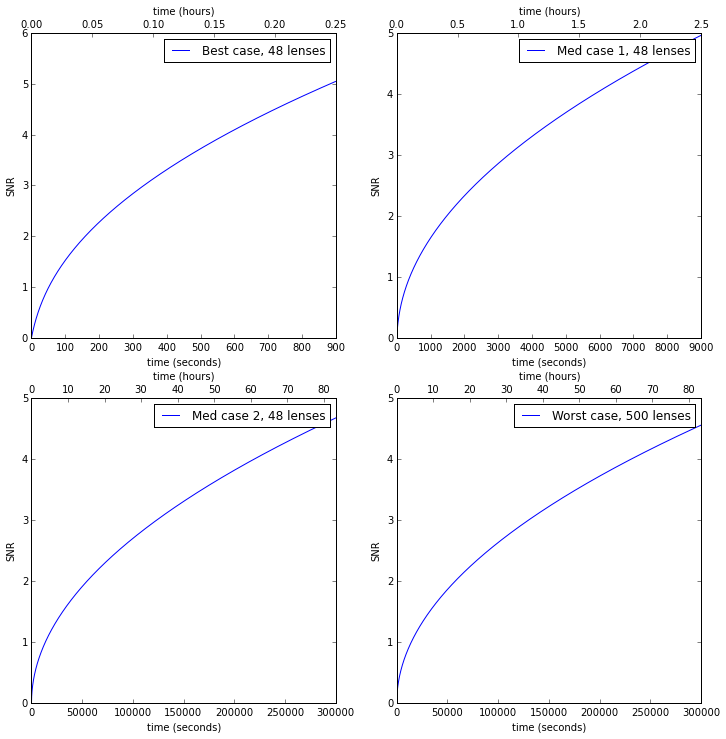

In [47]:
# Load values from Dragonfly instrumentation
[area_lens, ang_size_pixel, tau_l, tau_f, QE, B, D, R_squared, numpixels] = Dragonfly()

B_tot = B * QE * tau_l * tau_f * 3.*u.nm * area_lens.to(u.m**2) * ang_size_pixel.to(u.arcsec**2)
print('Background Sky: ' +str(B_tot))

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(12,12))

time = np.arange(0,900.) * u.second   # Exposure Times 

signal_max  = SB_Halpha_max  * QE * tau_l * tau_f * area_lens * ang_size_pixel *time*numpixels
sigma_max  = np.sqrt(signal_max  + B_tot*time*numpixels + D*time*numpixels + R_squared*numpixels)
one = ax1.plot(time, signal_max/sigma_max,label='Best case, 48 lenses')
ax1.set_xlabel('time (seconds)')
ax1.set_ylabel('SNR')
ax8 = ax1.twiny()
ax8.set_xlim(0,900./3600.)
ax8.set_xlabel('time (hours)')
ax1.legend()

time = np.arange(0,9000.) * u.second   # Exposure Times 

signal_med1 = SB_Halpha_med1 * QE * tau_l * tau_f * area_lens * ang_size_pixel *time*numpixels
sigma_med1 = np.sqrt(signal_med1 + B_tot*time*numpixels + D*time*numpixels + R_squared*numpixels)
two= ax2.plot(time, signal_med1/sigma_med1,label='Med case 1, 48 lenses')
ax2.set_xlabel('time (seconds)')
ax2.set_ylabel('SNR')
ax7 = ax2.twiny()
ax7.set_xlim(0,9000./3600.)
ax7.set_xlabel('time (hours)')
ax2.legend()

time = np.arange(0,300000.) * u.second   # Exposure Times 
print(area_lens)
signal_med2 = SB_Halpha_med2 * QE * tau_l * tau_f * area_lens * ang_size_pixel *time*numpixels
sigma_med2 = np.sqrt(signal_med2 + B_tot*time*numpixels + D*time*numpixels + R_squared*numpixels)
three=ax3.plot(time, signal_med2/sigma_med2,label='Med case 2, 48 lenses')
ax3.set_xlabel('time (seconds)')
ax3.set_ylabel('SNR')
ax6 = ax3.twiny()
ax6.set_xlim(0,300000./3600.)
ax6.set_xlabel('time (hours)')
ax3.legend()

area_lens = area_lens*10.
B_tot = B * QE * tau_l * tau_f * 3.*u.nm * area_lens.to(u.m**2) * ang_size_pixel.to(u.arcsec**2)
time = np.arange(0,300000.) * u.second   # Exposure Times 
print(area_lens)
signal_min  = SB_Halpha_min  * QE * tau_l * tau_f * area_lens * ang_size_pixel *time*numpixels
sigma_min  = np.sqrt(signal_min  + B_tot*time*numpixels + D*time*numpixels + R_squared*numpixels)
four = ax4.plot(time, signal_min/sigma_min,label='Worst case, 500 lenses')
ax4.set_xlabel('time (seconds)')
ax4.set_ylabel('SNR')
ax5 = ax4.twiny()
ax5.set_xlim(0,300000/3600.)
ax5.set_xlabel('time (hours)')
ax4.legend()

plt.savefig('FigSNRclouds.pdf')
#print(signal_med2[9000])
#print(signal_min[9000])
#print(sigma_med2[9000])
#print(sigma_min[9000])

The best case scenario is definitely doable.  The medium cases are pushing it, need to increase time by a factor of ten (at least) additionally for each case.

For the worst case, it appears that we would need 500 Dragonfly lenses and then integrate for an exposure time of ~80 hours.

Need to answer:
1.  Which case is the most likely?
2.  Would Donahue et al (2014) have seen the best case?  (if so, should scratch that one)
3.  What is the physics for that the Halpha emission rate is 0.45 times the ionization background?


1. 
2. In their Table 2, they give limits for the Halpha in the two non-detection fields of $1.62 * 10^{-19}$ erg/s/cm^2/arcsec^2 and $3.68 * 10^{-19}$ erg/s/cm^2/arcsec^2 (I believe these correspond to the limits of the confidence intervals that they calculated for each set of boxes for each field http://evolution.gs.washington.edu/gs560/2011/lecture3.pdf).  These correspond to $\sim$ 2277 ph/cm^2/sr/s and 5172 ph/cm^2/sr/s.  So they would have observed the best case of Halpha emission, probably, but not the medium cases.  Do we have any other advantage over this group, other than the times two detection rate?
3. 

In [61]:
wavelen = 656.3e-9 * u.m
SB_cgs = 3.68*10**-19 * u.erg / u.second / (u.cm**2) / u.arcsec**2
SB_ph  = SB_cgs * wavelen / (const.h.cgs * const.c) / (u.arcsec.to(u.rad) * u.rad/u.arcsec)**2 * u.photon
print(SB_ph)

5172.77746087 ph / (cm2 rad2 s)


In [62]:
sigma_rms = 0.113 # adu
sigma_rms * 3.09e-18

3.4917000000000005e-19

In [63]:
2.086*0.108/np.sqrt(20)
2.131*0.224/np.sqrt(15)

0.12324969082746885

In [64]:
5*10**-4.6 * 0.5 * u.Mpc.to(u.cm)

1.9377179122251858e+20

Investigating the sky background flux:

In [65]:
wavelen = [ 654.78,  655.04,  655.31,  655.57,  655.84,  656.1 ,  656.37,
        656.63,  656.9 ,  657.16,  657.43,  657.69,  657.96]
flux = [0.4887,  0.5453,  0.5547,  0.5547,  0.4976,  0.4889,  0.4716,
        0.5385,  0.5485,  0.5556,  0.5179,  0.5079,  0.5077]
wavelen = np.array(wavelen,'d')
flux = np.array(flux,'d')

0.521353846154
(654.8, 657.8)
13


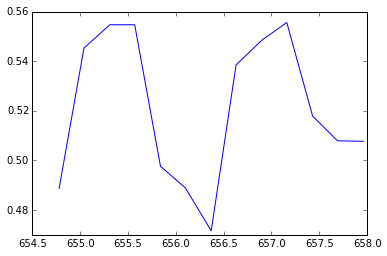

In [66]:
print(np.mean(flux))
print(656.3-1.5,656.3+1.5)
print(len(flux))
plt.plot(wavelen,flux)

In [67]:
delta_nm = 3. / len(flux)
sum_flux = np.sum(flux*delta_nm)
print(sum_flux)
print(np.mean(flux)*3.)

1.56406153846
1.56406153846


Those are weirdly the exact same value... So we can just use the mean sky background flux in this 3nm range, which is 0.52135.